# THIS IS DEPRECATED

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic
from unyt import erg, s

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility.stats import weighted_median, binned_weighted_quantile
import utils as u


# Set a random number seed to ensure consistent results
np.random.seed(42)

initialised cosmology
no FLARES_MASTER environment variable set
6.446e+23 g/s


In [2]:
# set style
plt.style.use('../matplotlibrc.txt')

## get data

In [3]:
# get data
blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, eddington_ratio, weights = u.load_all_blackhole_data()

# print(blackhole_mass)
print('total number of BHs', len(blackhole_mass))

selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

selection = bolometric_luminosity.to('erg/s').value > 1E30

print(np.sum(selection))

blackhole_mass = blackhole_mass[selection]
blackhole_accretion_rate = blackhole_accretion_rate[selection]
bolometric_luminosity = bolometric_luminosity[selection]
weights = weights[selection]

conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

print(np.sum(conservative_selection))


selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'



total number of BHs 237437
107701
111


/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


First we need to initialise our `BlackHole` object with the parameters that will be needed to compute spectra.

In [4]:

blackholes = BlackHoles(
    masses=blackhole_mass,
    accretion_rates=blackhole_accretion_rate,
)


print(np.min(blackholes.bolometric_luminosity), np.max(blackholes.bolometric_luminosity))

1.0038406643144703e+30 erg/s 3.7283443046101927e+46 erg/s


## Generating spectral energy distribution

We can generate spectra by passing a blackhole emission model (e.g. the `UnifiedAGN` model described in [emission_models](emission_models.ipynb)) to the spectra creation method (`get_intinsic_spectra`).

## Open the disc grid

In [5]:

grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

print(grid)

+----------------------------------------------------------------------------------------------------------------+
|                                                      GRID                                                      |
+--------------------------------+-------------------------------------------------------------------------------+
| Attribute                      | Value                                                                         |
+--------------------------------+-------------------------------------------------------------------------------+
| grid_dir                       | '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'                       |
+--------------------------------+-------------------------------------------------------------------------------+
| grid_name                      | 'qsosed-isotropic'                                                            |
+--------------------------------+----------------------------------------------

# Initialise the emission model

In [6]:

emission_model = DiscIncidentEmission(grid)


### Generate quantities 

In [7]:
# get the spectra assuming this emission model
blackholes.get_particle_spectra(emission_model)


spectra = blackholes.particle_spectra['disc_incident']

ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

print(np.min(ionising_photon_luminosity), np.max(ionising_photon_luminosity))

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

halpha_luminosity = ionising_photon_luminosity * u.ionising_to_Halpha_conversion

print(np.min(halpha_luminosity), np.max(halpha_luminosity))



/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/1435528269.py:2: FutureWarning: get_particle_spectra is now just a wrapper around get_spectra. It will be removed by v1.0.0.
  blackholes.get_particle_spectra(emission_model)


4.1199174953702507e+39 1/s 4.913380632717628e+56 1/s
1.2631667040805189e+28 erg/s 1.5064425019912248e+45 erg/s


## Ionising photon luminosity function

/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


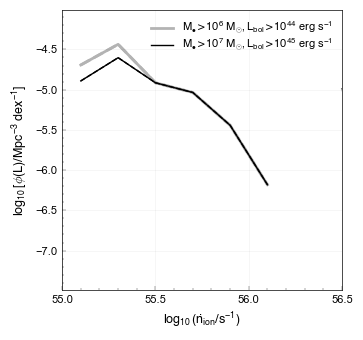

In [8]:
X_limits = [55, 56.5]
Y_limits = [-7.49, -4.01]

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))



binw = 0.2
bin_edges = np.arange(55., 57, binw)
bin_centres = bin_edges[:-1]+binw/2

# full selection
x = np.log10(ionising_photon_luminosity.to('1/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights)

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), ls ='--', c='0.7', lw=2, zorder=1)
ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='0.7', lw=2, zorder=1, label=selection_label)

# conservative selection
x = np.log10(ionising_photon_luminosity[conservative_selection].to('1/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[conservative_selection])

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), ls ='--', c='k', lw=1, zorder=2)
ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='k', lw=1, zorder=2, label=conservative_selection_label)


ax.legend(fontsize=8, labelspacing=0.1)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
ax.set_xticks([55., 55.5, 56.0, 56.5])

ax.set_ylabel(r'$\rm \log_{10}[\phi(L)/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(\dot{n}_{ion}/s^{-1})$')



fig.savefig(f'figures/ionising_luminosity_function.pdf')
plt.show()
fig.clf()



## H-alpha luminosity function

For different values of fcov and assuming f_BLR=0.8

In [9]:


f_blr = 0.8

ntot = len(halpha_luminosity)
print(f'total: {ntot}')

size = int(ntot * f_blr)
print(f'selected: {size}')

fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

print(f'selection: {len(fblr_selection)}')

x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value)
print(x)

total: 107701
selected: 86160
selection: 86160
[31.74615919 33.61122709 32.71167503 ... 32.84006564 30.99855496
 35.85945754]


In [10]:
# observations (Matthee+)

observations = {}

observations['Matthee+24'] = {}

observations['Matthee+24']['x'] = np.array([42.5, 42.9, 43.5])
observations['Matthee+24']['y'] = np.array([-4.2, -4.74, -5.36])

observations['Matthee+24']['xerr'] = np.array([[0.2, 0.2, 0.4],[0.2, 0.2, 0.4]])
observations['Matthee+24']['yerr'] = np.array([[0.14, 0.3, 0.53],[0.10, 0.18,0.23]])

/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/4171749800.py:113: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(stellar_halpha_luminosity.to('erg/s').value)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/4171749800.py:125: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)


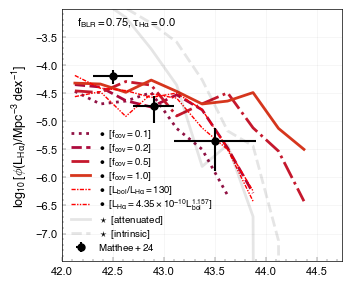

In [41]:


X_limits = [42., 44.75]
Y_limits = [-7.49, -3.01]

fig = plt.figure(figsize = (3.5, 2.8))

# left  = 0.15
# height = 0.8
# bottom = 0.15
# width = 0.8

left  = 0.15
height = 0.9
bottom = 0.05
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.3, r'$\rm f_{BLR}=0.75, \tau_{H\alpha}=0.0$', fontsize=8)

binw = 0.25
bin_edges = np.arange(42., 44.75, binw)
bin_centres = bin_edges[:-1]+binw/2


phi = {}

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for fcov, ls, col in zip([0.1, 0.2, 0.5, 1.0], [':', '--','-.', '-',], colours):

    # full selection
    x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)



    N, _ = np.histogram(x, bins = bin_edges)
    
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

    Nw[Nw==0.0] = 1E-100

    phi[fcov] = (Nw / u.volume) / binw

    ax.plot(bin_centres[N>4], np.log10(phi[fcov][N>4]), c=col, lw=2, zorder=1, ls=ls, label=rf'$\rm \bullet\ [f_{{cov}}={fcov}]$')

    # ax.plot(bin_centres, np.log10(phi), ls ='--', c='0.7', lw=2, zorder=1)
    # ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='0.7', lw=2, zorder=1)

    # conservative selection
    # x = np.log10(halpha_luminosity[conservative_selection].to('erg/s').value) + np.log10(fcov)

    # N, _ = np.histogram(x, bins = bin_edges)
    # Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[conservative_selection])

    # phi = (Nw / u.volume) / binw

    # ax.plot(bin_centres, np.log10(phi), ls ='--', c='k', lw=1, zorder=2)
    # ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='k', lw=1, zorder=2)



# With constant bolometric correction

x = np.log10(spectra.bolometric_luminosity[fblr_selection].to('erg/s').value) + np.log10(1./130.)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

Nw[Nw==0.0] = 1E-100

phi[fcov] = (Nw / u.volume) / binw

ax.plot(bin_centres[N>4], np.log10(phi[fcov][N>4]), c='r', lw=1, zorder=1, ls=(0, (3, 1, 1, 1)), label=r'$\rm \bullet\ [L_{bol}/L_{H\alpha}=130]$')


# With luminosity dependent bolometric correction


def bolometric_luminosity_to_halpha_luminosity(bolometric_luminosity):
    return 5.25E42*(bolometric_luminosity/1E44/10.33)**(1.157) 

def bolometric_luminosity_to_halpha_luminosity(bolometric_luminosity):
    return 4.35E-10*(bolometric_luminosity)**(1.157) 


x = np.log10(bolometric_luminosity_to_halpha_luminosity(spectra.bolometric_luminosity[fblr_selection].to('erg/s').value))

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

Nw[Nw==0.0] = 1E-100

phi[fcov] = (Nw / u.volume) / binw

ax.plot(bin_centres[N>4], np.log10(phi[fcov][N>4]), c='r', lw=1, zorder=1, ls=(0, (3, 1, 1, 1, 1, 1)), label=r'$\rm \bullet\ [L_{H\alpha}=4.35\times 10^{-10}L_{bol}^{1.157}]$')




# add galaxy H-alpha LF

stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563/', 'Luminosity'],
    units=erg/s, 
)

intrinsic_stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563/', 'Luminosity'],
    units=erg/s, 
)


x = np.log10(stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='-', alpha=0.1, label=r'$\rm \star\ [attenuated]$')


x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='--', alpha=0.1, label=r'$\rm \star\ [intrinsic]$')

# add observations
for study in observations.keys():
    ob = observations[study]
    ax.errorbar(ob['x'], ob['y'], xerr=ob['xerr'], yerr=ob['yerr'], fmt='o', c='k', label=rf'$\rm {study}$', ms=5)

ax.legend(fontsize=7, labelspacing=0.1)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
# ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fcov.pdf')
plt.show()
fig.clf()







selected: 26925
selected: 53850
selected: 80775
selected: 107701


/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/3874847197.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(stellar_halpha_luminosity.to('erg/s').value)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/3874847197.py:73: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)


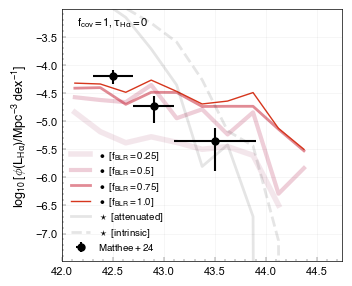

In [42]:

# This makes sense since this figure is the first in the series.
fcov = 1.0

fig = plt.figure(figsize = (3.5, 2.8))

# left  = 0.15
# height = 0.8
# bottom = 0.15
# width = 0.8

left  = 0.15
height = 0.9
bottom = 0.05
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.3, r'$\rm f_{cov}=1, \tau_{H\alpha}=0$', fontsize=8)

phi = {}

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for f_blr, lw, alpha, col in zip([0.25, 0.5, 0.75, 1.0], [4,3,2,1], [0.1, 0.2, 0.5, 1.0], colours):


    size = int(ntot * f_blr)
    print(f'selected: {size}')

    fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)


    # full selection
    x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)

    N, _ = np.histogram(x, bins = bin_edges)
    
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

    Nw[Nw==0.0] = 1E-100

    phi[fcov] = (Nw / u.volume) / binw

    ax.plot(bin_centres[N>4], np.log10(phi[fcov][N>4]), c=col, lw=lw, zorder=1, ls='-', alpha=alpha, label=rf'$\rm \bullet\ [f_{{BLR}}={f_blr}]$')



# add galaxy H-alpha LF

stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563/', 'Luminosity'],
    units=erg/s, 
)

intrinsic_stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563/', 'Luminosity'],
    units=erg/s, 
)


x = np.log10(stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='-', alpha=0.1, label=r'$\rm \star\ [attenuated]$')


x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='--', alpha=0.1, label=r'$\rm \star\ [intrinsic]$')

# add observations
for study in observations.keys():
    ob = observations[study]
    ax.errorbar(ob['x'], ob['y'], xerr=ob['xerr'], yerr=ob['yerr'], fmt='o', c='k', label=rf'$\rm {study}$', ms=5)



ax.legend(fontsize=7, labelspacing=0.25)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
# ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fblr.pdf')
plt.show()
fig.clf()

For CONGRESS:
log $L_{\textrm{H}\alpha}$ & N & $<c>$ & $\phi_\textrm{comp}$\\
$\textrm{erg}\;\textrm{s}^{-1}$&  &  & $10^{-3}\;\textrm{Mpc}^{-3}$ \\
42.00 & 4 & 0.75 & $0.136_{-0.068}^{+0.109}$ \\
43.00 & 1 & 0.82 & $0.031_{-0.026}^{+0.071}$ \\

For FRESCO:
log $L_{\textrm{H}\alpha}$ & N & $<c>$ & $\phi_\textrm{comp}$\\
$\textrm{erg}\;\textrm{s}^{-1}$&  &  & $10^{-3}\;\textrm{Mpc}^{-3}$ \\
42.00 & 4 & 0.86 & $0.047_{-0.023}^{+0.037}$ \\
42.50 & 3 & 0.87 & $0.034_{-0.019}^{+0.034}$ \\
43.00 & 1 & 0.88 & $0.011_{-0.009}^{+0.026}$ \\



## Add dust attenuation

/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/346307442.py:42: RuntimeWarning: invalid value encountered in subtract
  log10fesc = np.log10(stellar_halpha_luminosity[selection]) - np.log10(intrinsic_stellar_halpha_luminosity[selection])
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/346307442.py:72: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(stellar_halpha_luminosity.to('erg/s').value)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16210/346307442.py:84: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)


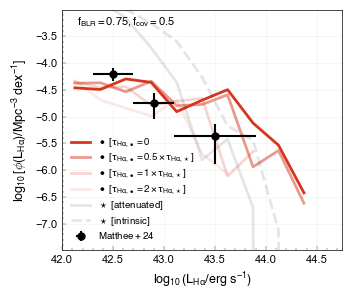

In [45]:


fig = plt.figure(figsize = (3.5, 3.))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.3, r'$\rm f_{BLR}=0.75, f_{cov}=0.5$', fontsize=8)



phi = {}

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

# full selection, fcov=0.5, no dust
fcov = 0.5
x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)
N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])
Nw[Nw==0.0] = 1E-100
phi[fcov] = (Nw / u.volume) / binw
ax.plot(bin_centres[N>4], np.log10(phi[fcov][N>4]), c=col, lw=2, zorder=1, ls=ls, label=rf'$\rm \bullet\ [\tau_{{H\alpha, \bullet}}=0$')

# including the same attenuation as felt by the galaxy



stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563/', 'Luminosity'],
    units=erg/s, 
)

intrinsic_stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563/', 'Luminosity'],
    units=erg/s, 
)


log10fesc = np.log10(stellar_halpha_luminosity[selection]) - np.log10(intrinsic_stellar_halpha_luminosity[selection])

dust_scales = [0.5, 1, 2]

for dust_scale, alpha in zip(dust_scales, [0.5, 0.2, 0.1]):

    x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov) + log10fesc[fblr_selection] - np.log10(dust_scale)
    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])
    Nw[Nw==0.0] = 1E-100
    phi[fcov] = (Nw / u.volume) / binw
    ax.plot(
        bin_centres[N>4], 
        np.log10(phi[fcov][N>4]), 
        c=col, 
        lw=2, 
        zorder=1, 
        ls=ls, 
        alpha=alpha,
        label=rf'$\rm \bullet\ [\tau_{{H\alpha, \bullet}}={dust_scale}\times\tau_{{H\alpha, \star}}]$')








# add galaxy H-alpha LF

x = np.log10(stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='-', alpha=0.1, label=r'$\rm \star\ [attenuated]$')


x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=stellar_weights)

Nw[Nw==0.0] = 1E-100

phi = (Nw / u.volume) / binw

ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='--', alpha=0.1, label=r'$\rm \star\ [intrinsic]$')

# add observations
for study in observations.keys():
    ob = observations[study]
    ax.errorbar(ob['x'], ob['y'], xerr=ob['xerr'], yerr=ob['yerr'], fmt='o', c='k', label=rf'$\rm {study}$', ms=5)

ax.legend(fontsize=7, labelspacing=0.25)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fesc.pdf')
plt.show()
fig.clf()

0.0 erg/s 1.074355534718146e+44 erg/s
(107701,)
52728


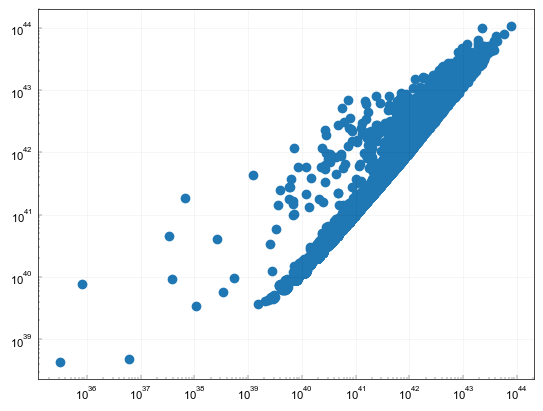

/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


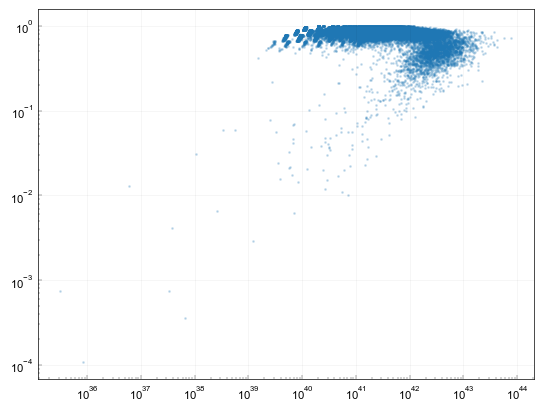

In [26]:
stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563/', 'Luminosity'],
    units=erg/s, 
)

intrinsic_stellar_halpha_luminosity, stellar_weights = u.load_all_dataset(
    dataset_id=['Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563/', 'Luminosity'],
    units=erg/s, 
)


print(np.min(stellar_halpha_luminosity[selection]), np.max(intrinsic_stellar_halpha_luminosity[selection]))

print(stellar_halpha_luminosity[selection].shape)
print(np.sum(stellar_halpha_luminosity[selection]==0.0))

plt.scatter(stellar_halpha_luminosity, intrinsic_stellar_halpha_luminosity)
plt.xscale('log')
plt.yscale('log')
plt.show()



plt.scatter(stellar_halpha_luminosity, stellar_halpha_luminosity/intrinsic_stellar_halpha_luminosity, s=1, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()